# Regression LSTM with best parameters
    find the best prediction window to apply w/ lr = 0.0001

# Import libraries

In [1]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import matplotlib.pyplot as plt
import pandas as pd;
import numpy as np;
import sklearn
import time

dates = [2018010000, 
         2018030000, 
         2018050000,
         2018070000, 
         2018090000, 
         2018110000]

     |████████████████████████████████| 10.5 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 68.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 73.0 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=7c51b21020011beb86f44738e1097ba366c9c8856949424cf05d0117aadc2a2f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
     |████████████████████████████████| 11.5 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 17.6 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 14.8 MB/s eta 0:00:01


# Import keras libraries, packages and data:

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

mae_gen = []
rmse_gen = []
mae_nor = []
mae_spi = []
rmse_nor = []
rmse_spi = []
hist_list = []
y_pred_list = []
prediction_list = []
time_count = []

# import data
data_full = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# parameters
features_num = 15
steps = 96
n_hidden = 1
units = 150
batch_size = 96
epochs = 180

Using TensorFlow backend.


# Create loop for different dates:

In [3]:
# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# design the LSTM
def regressor_tunning(bias_initializer = initializers.Ones() , kernel_initializer = 'he_normal'):
    model = Sequential()
    if n_hidden == 0:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop(lr = 0.0001)
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
    return model

  
# LOOP STARTS
for i in dates:
    start_time = time.time()
    # data
    data = data_full.loc[data_full.index > 2018070000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # fill nan values
    data.fillna(method = 'ffill', inplace = True)

    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    data_train, data_test = train_test_split(
             data, test_size = 0.15, shuffle=False)    
    
    from sklearn.preprocessing import MinMaxScaler

    # data scaling  (including offer (y))
    sc_X = MinMaxScaler()
    data_train = sc_X.fit_transform(data_train)
    data_test = sc_X.transform(data_test)
    
    # divide features and labels
    X_train = data_train[:, 0:15] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:15] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.15, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    X_train = cut_data(X_train, batch_size)
    y_train = cut_data(y_train, batch_size)
    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)
    X_val = cut_data(X_val, batch_size)
    y_val = cut_data(y_val, batch_size)

    model = regressor_tunning()
    
    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = epochs,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15 (inverso should not be used as scalling was made with the whole data set)
    y_pred = (y_pred * sc_X.data_range_[15]) + (sc_X.data_min_[15])
    y_test = (y_test * sc_X.data_range_[15]) + (sc_X.data_min_[15])

    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)
    
    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)
    
    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 67s 11ms/step - loss: 0.1942 - mse: 0.1942 - mae: 0.3488 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0817
Epoch 2/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.1221 - mse: 0.1221 - mae: 0.2765 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0347
Epoch 3/180
6240/6240 [==============================] - 59s 10ms/step - loss: 0.0768 - mse: 0.0768 - mae: 0.2204 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0451
Epoch 4/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.0529 - mse: 0.0529 - mae: 0.1834 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0227
Epoch 5/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0350 - mse: 0.0350 - mae: 0.1486 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0326
Epoch 6/180
6240/6240 [==============================] - 59s 10ms/step - loss: 0.0246 - mse: 0.0246 - mae: 0.

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 62s 10ms/step - loss: 0.1965 - mse: 0.1965 - mae: 0.3503 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0404
Epoch 2/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.1239 - mse: 0.1239 - mae: 0.2788 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0694
Epoch 3/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0818 - mse: 0.0818 - mae: 0.2274 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0380
Epoch 4/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1824 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0483
Epoch 5/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1451 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0210
Epoch 6/180
6240/6240 [==============================] - 59s 10ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.1895 - mse: 0.1895 - mae: 0.3384 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0854
Epoch 2/180
6240/6240 [==============================] - 59s 10ms/step - loss: 0.1132 - mse: 0.1132 - mae: 0.2683 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0452
Epoch 3/180
6240/6240 [==============================] - 59s 10ms/step - loss: 0.0725 - mse: 0.0725 - mae: 0.2133 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0403
Epoch 4/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.0499 - mse: 0.0499 - mae: 0.1767 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0458
Epoch 5/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1424 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0302
Epoch 6/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 61s 10ms/step - loss: 0.1796 - mse: 0.1796 - mae: 0.3363 - val_loss: 0.0161 - val_mse: 0.0161 - val_mae: 0.1168
Epoch 2/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.1152 - mse: 0.1152 - mae: 0.2699 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0904
Epoch 3/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.0724 - mse: 0.0724 - mae: 0.2142 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0676
Epoch 4/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.1758 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0579
Epoch 5/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0319 - mse: 0.0319 - mae: 0.1422 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0394
Epoch 6/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.108

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 61s 10ms/step - loss: 0.1820 - mse: 0.1820 - mae: 0.3375 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0739
Epoch 2/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.1158 - mse: 0.1158 - mae: 0.2711 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0279
Epoch 3/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0735 - mse: 0.0735 - mae: 0.2163 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0412
Epoch 4/180
6240/6240 [==============================] - 59s 9ms/step - loss: 0.0447 - mse: 0.0447 - mae: 0.1695 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0574
Epoch 5/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1334 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0295
Epoch 6/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.10

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Train on 6240 samples, validate on 960 samples
Epoch 1/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.1649 - mse: 0.1649 - mae: 0.3179 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0366
Epoch 2/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.1004 - mse: 0.1004 - mae: 0.2493 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0311
Epoch 3/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0638 - mse: 0.0638 - mae: 0.2007 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0473
Epoch 4/180
6240/6240 [==============================] - 60s 10ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1622 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0244
Epoch 5/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0270 - mse: 0.0270 - mae: 0.1309 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0326
Epoch 6/180
6240/6240 [==============================] - 58s 9ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.104

In [4]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
    
                        'time': time_count})

In [5]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,32.713897,21.318353,30.023154,20.279802,33.094961,21.472634,10654.053765
1,32.737088,20.172003,28.087976,18.791572,33.372526,20.377072,10578.304755
2,32.645225,20.129986,28.043467,17.629253,33.274588,20.501481,10557.427510
3,34.553562,22.170887,26.584995,17.995326,35.585423,22.791184,10620.167211
4,32.475994,20.560569,27.801388,19.358999,33.114178,20.739068,10527.877661
5,32.824793,20.197717,26.248326,16.318331,33.692421,20.774016,10567.632611


In [6]:
results.min()

rmse_general       32.475994
mae_general        20.129986
rmse_spike         26.248326
mae_spike          16.318331
rmse_normal        33.094961
mae_normal         20.377072
time            10527.877661
dtype: float64

In [7]:
!pip install matplotlib

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


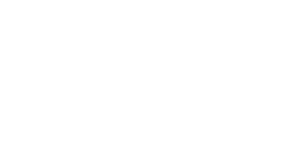

<IPython.core.display.Javascript object>


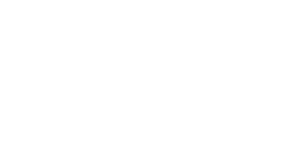

In [10]:
%matplotlib notebook

dates_labels = ['12 ',
                '10 ',
                '8 ',
                '6 ',
                '4 ',
                '2 ']

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged RMSE for different\n predictive windows')
plt.plot(rmse_gen, label = 'Overall error')
plt.plot(rmse_spi, label = 'Spike regions')
plt.plot(rmse_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4,5], dates_labels)
plt.tight_layout()
plt.savefig('RMSE_predictive_window.png')

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged MAE for different\n predictive windows')
plt.plot(mae_gen, label = 'Overall error')
plt.plot(mae_spi, label = 'Spike regions')
plt.plot(mae_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4,5], dates_labels)
plt.tight_layout()
plt.savefig('MAE_predictive_window.png')